### 1. Import and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,ECOID
0,2504,2371,1.0,0,133,2437.5,1,0
1,2487,2596,0.5,0,109,2541.5,0,0
2,2915,2921,0.5,0,6,2918.0,0,0
3,2542,2433,1.0,0,109,2487.5,1,10
4,2473,2658,0.0,0,185,2565.5,0,0


### 2. Prepare data

In [3]:
X = df.drop("ResultNumeric", axis=1)
y = df["ResultNumeric"]

# 0 = Black Win, 1 = Draw, 2 = White Win
y = y.map({0.0: 0, 0.5: 1, 1.0: 2})

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (3266132, 7)
Target: (3266132,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=y,
)

#### Scale feature

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Train model

In [6]:
lr_model = LogisticRegression(
    max_iter=2000,
    solver="saga",
    random_state=42,
    n_jobs=-1,
)

In [7]:
start_time = time.time()

lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(
    f"Training completed in {training_time:.2f} seconds ({training_time / 60:.2f} minutes)"
)

Training completed in 22.13 seconds (0.37 minutes)


### 5. Evaluate

In [8]:
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)\n")

print("Classification Report: \n")
print(
    classification_report(
        y_test, y_pred, target_names=["Black Win", "Draw", "White Win"]
    )
)

Accuracy: 0.5812 (58.12%)

Classification Report: 

              precision    recall  f1-score   support

   Black Win       0.56      0.56      0.56    267660
        Draw       0.77      0.28      0.41     84135
   White Win       0.58      0.69      0.63    301432

    accuracy                           0.58    653227
   macro avg       0.64      0.51      0.53    653227
weighted avg       0.60      0.58      0.57    653227



### 6. Confusion Matrix

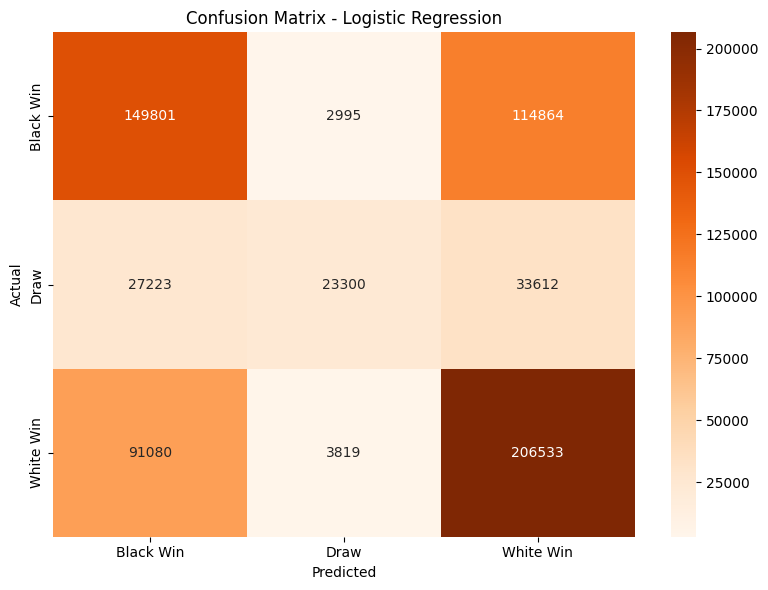

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["Black Win", "Draw", "White Win"],
    yticklabels=["Black Win", "Draw", "White Win"],
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

### 7. Coefficients (Feature importance for linear models)

              Feature  Coefficient
1            BlackElo     0.335984
0            WhiteElo     0.301974
4           AvgRating     0.123974
2         EventTypeID     0.101144
3          RatingDiff     0.061252
6               ECOID     0.017964
5  WhiteIsHigherRated     0.009223


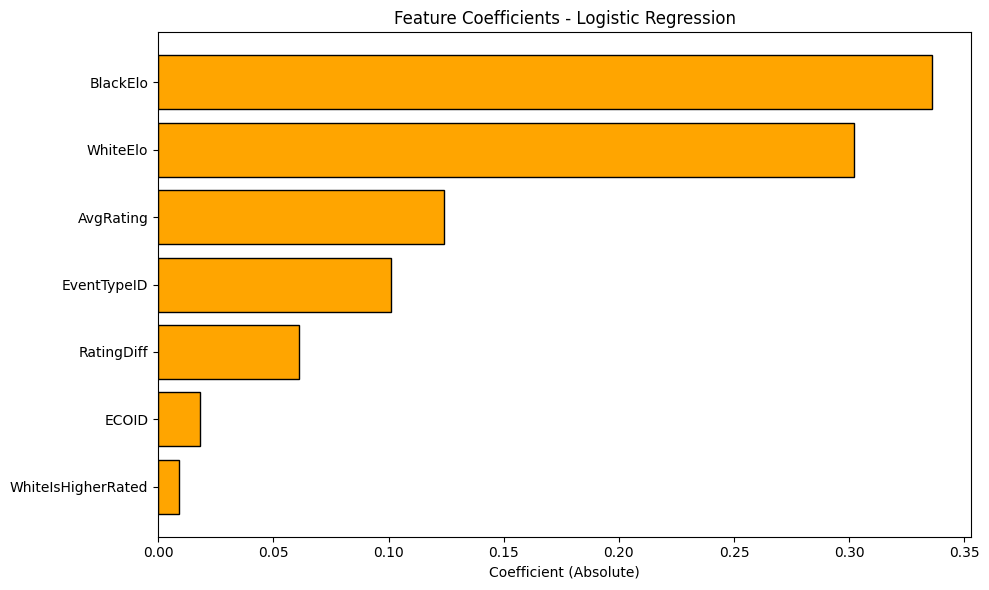

In [10]:
coef_df = pd.DataFrame(
    {
        "Feature": X.columns,
        "Coefficient": np.abs(lr_model.coef_).mean(axis=0),  # Average across classes
    }
).sort_values("Coefficient", ascending=False)

print(coef_df)

plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="orange", edgecolor="black")
plt.xlabel("Coefficient (Absolute)")
plt.title("Feature Coefficients - Logistic Regression")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()